## Discovering my interests in Hacker News with NLP
# Part III: Rock'n'Roll, Topic modelling and analysis

In [13]:
import spacy
import gensim
import pandas as pd
from typing import Union, Tuple, List
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

1. Load scraped content (from "HN Scrapping")

In [2]:
df = pd.read_pickle('hn_favs_scrapped.pickle')
scrapped_urls = df.to_dict('records')

## 1. HTML -> Features

In [3]:
class ScrapedWeb(object):
    """
    Scraped web (POJO)
    """
    def __init__(self, url: str, title: str, description: str, headings: List[str], contents: List[str], dom: BeautifulSoup):
        
        self.url = url
        self.title = title
        self.description = description
        self.headings = headings
        self.contents = contents
        self.dom = dom

    def __str__(self):
        
        return f"'{self.title}' @ {self.url}"

    def __repr__(self):
        
        return f"{self.title}"

In [4]:
class ScrapedWebVitamined(ScrapedWeb):
    """
    Scraped web with vitamines and steroids (augmented and functions)
    """
    
    def wordsWeighted(self, wTitle=10, wHeadings=4):
        """
        Get all content as list of words.
        Frequency matters, so the words in "title" or "headings" worth more than in the rest of contents
        """
        words = []
        # Title
        if self.title:
            words += [x.strip().lower() for x in self.title.replace('\n', ' ').replace('\t', ' ').split(" ")] * wTitle
        # Headings
        words += [x.strip().lower() for y in self.headings for x in y.replace('\n', ' ').replace('\t', ' ').split(" ") if x != ''] * wHeadings
        # Content
        words += [x.strip().lower() for y in self.contents for x in y.replace('\n', ' ').replace('\t', ' ').split(" ") if x != '']
        return words

    def whole(self) -> List[str]:
        """
        Whole document by multiply sections for a weight factor (relevance)
        """
        return self.wholeWeighted(wTitle=1, wHeading=1)
    
    def wholeWeighted(self, wTitle=10, wHeading=4) -> List[str]:
        """
        Get whole webpage a list of strings
        """
        ret = []
        # Title
        if self.title:
            ret += [self.title] * wTitle
        # Headings
        ret += self.headings * wHeading
        # Content
        ret += [y.strip().lower() for x in self.contents for y in x.replace('\t', ' ').split('\n') if y.strip() != '']
        return ret
    
    def save(self, path: str):
        """
        Save whole info in "path"
        """
        with open(path, 'w') as w:
            if self.title:
                w.write(self.title + '\n---\n\n')
            for x in self.headings:
                w.write(f"- {x}\n\n")
            for x in self.contents:
                w.write(f"{x}\n")

In [5]:
def getDescription(dom: BeautifulSoup) -> Union[str, None]:
    """
    Get description
    """
    # 1. meta with property
    obj = dom.find('meta', property='description')
    if obj is not None:
        return obj.attrs.get('content')
    # 2. old HTML description
    obj = dom.find('meta', itemprop='description')
    if obj is not None:
        return obj.attrs.get('content')
    # 3. meta desc with OG
    obj = dom.find('meta', property='og:description')
    if obj is not None:
        return obj.attrs.get('content')
    # Not found
    return None

In [6]:
def html2ScrapedWeb(url: str, html: str) -> ScrapedWebVitamined:
    """
    Parse HTML using BS4 HTML5Lib parser and get <body> content without
    <nav>, <script>, <footer>
    It's focus on content
    """
    dom = BeautifulSoup(html, 'html5lib')
    # 1. Get title
    title = dom.title.string if dom.title else None
    # 2. Get description
    desc = getDescription(dom)
    # 3. Remove undesired elements
    dropTags = ["script", "head", "nav", "footer"]
    for tag in dropTags:
        for elem in dom.find_all(tag):
            elem.decompose()
    # 4. Headings
    headings = [x.getText() for idx in range(6) for x in dom.find_all(f'h{idx+1}') if x]
    # 5. Content
    s = set()
    for x in dom.find_all(["p", "td", "li", "a"]):
        s.add(x.getText().strip())
    contents = list(s)
    return ScrapedWebVitamined(url, title, desc, headings, contents, dom)

In [7]:
docs_ww = []
idx = 1
for item in tqdm(scrapped_urls):
    try:
        sw = html2ScrapedWeb(item['url'], item['content'])
        idx += 1
    except Exception as err:
        print(f'Error: {err}')
        continue
    docs_ww.append(sw.wholeWeighted())

## 2. Pre-processing words

In [8]:
nlp = spacy.load('en_core_web_lg')

In [9]:
def lemmatizer(doc):
    """
    This takes in a doc of tokens from the NER and lemmatizes them. 
    Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    """
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    """
    This will remove stopwords and punctuation.
    Use token.text to return strings, which we'll need for Gensim.
    """
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

In [18]:
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

Pre-processing all docs

In [19]:
docs = []
for item in tqdm(docs_ww):
    docs.append(nlp('.'.join(item)))


## Create LDA model

In [15]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [20]:
words = corpora.Dictionary(docs)
print(f'Words in corpora: {len(words)}')

Words in corpora: 31672


In [21]:
corpus = [words.doc2bow(doc) for doc in docs]

## Determining the "best" number of topics

In [22]:
perplexities = []
coherence = []
num_topics = [3,4] + list(range(5, 175, 10))
for nt in tqdm(num_topics):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=nt, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    perplexities.append(lda_model.log_perplexity(corpus))
    coherence_lda_model = CoherenceModel(model=lda_model, texts=docs, dictionary=words, coherence='c_v')
    print(f"Num: {nt} - Per: {lda_model.log_perplexity(corpus)} - Coh: {coherence_lda_model.get_coherence()}")
    coherence.append(coherence_lda_model.get_coherence())

Num: 3 - Per: -8.658015016613103 - Coh: 0.32710010094669245
Num: 4 - Per: -8.606967422835455 - Coh: 0.3613588019033284
Num: 5 - Per: -8.559466427009701 - Coh: 0.38907401430499655
Num: 15 - Per: -8.31285008629187 - Coh: 0.4074409500238248
Num: 25 - Per: -8.464358076387178 - Coh: 0.39853330935005815
Num: 35 - Per: -9.027243791475442 - Coh: 0.3863612754651351
Num: 45 - Per: -9.805849156845136 - Coh: 0.3901934044055561
Num: 55 - Per: -10.31238716515848 - Coh: 0.39533500889864714
Num: 65 - Per: -10.77317237860635 - Coh: 0.3868664840771136
Num: 75 - Per: -11.39985150746682 - Coh: 0.4088457637372283
Num: 85 - Per: -11.952800671084981 - Coh: 0.40385990790226334
Num: 95 - Per: -12.662183171956555 - Coh: 0.40938282016378014
Num: 105 - Per: -13.175058611210915 - Coh: 0.4129436318084257
Num: 115 - Per: -13.627518583575979 - Coh: 0.40325259392660484
Num: 125 - Per: -13.960140887678143 - Coh: 0.4041790341374109
Num: 135 - Per: -14.778290724294315 - Coh: 0.4193543947530325
Num: 145 - Per: -15.1053696

In [24]:
import matplotlib.pyplot as plt

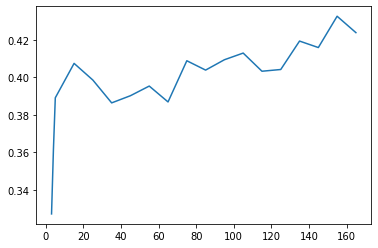

In [25]:
plt.plot(pd.DataFrame(coherence, index=num_topics))

In [26]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=15, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [27]:
lda_model.print_topics(num_topics=15, num_words=20)

[(0,
  '0.013*"mean" + 0.012*"|" + 0.011*"clustering" + 0.008*"learning" + 0.008*"unsupervised" + 0.007*"k" + 0.007*"datum" + 0.007*"card" + 0.007*"K" + 0.006*"use" + 0.005*"reality" + 0.005*"gathering" + 0.005*"learn" + 0.004*"apply" + 0.004*"magic" + 0.004*"news" + 0.004*"data" + 0.004*"augment" + 0.004*"deck" + 0.004*"story"'),
 (1,
  '0.008*"use" + 0.006*"   " + 0.005*"marketing" + 0.005*"email" + 0.005*"time" + 0.005*"content" + 0.004*"\n " + 0.004*"product" + 0.003*"user" + 0.003*"facebook" + 0.003*"datum" + 0.003*"ad" + 0.003*"guide" + 0.003*"create" + 0.003*"tool" + 0.003*"need" + 0.003*"+" + 0.003*"build" + 0.003*"business" + 0.003*"model"'),
 (2,
  '0.006*"model" + 0.006*"huginn" + 0.006*"visa" + 0.006*"martha" + 0.005*"user" + 0.005*"look" + 0.005*"datum" + 0.005*"h1b" + 0.004*"use" + 0.004*"agent" + 0.004*"address" + 0.004*"article" + 0.004*"H1B" + 0.004*"root" + 0.004*"phone" + 0.004*"cluster" + 0.003*"ip" + 0.003*"  " + 0.003*"mateo" + 0.003*"type"'),
 (3,
  '0.011*"use" 

In [29]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [30]:
pyLDAvis.gensim.prepare(lda_model, corpus, words)

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.098955  0.104169       1        1  15.669130
1      0.106244 -0.005791       2        1  12.742090
4      0.081984  0.000718       3        1  11.617631
3      0.050360  0.059171       4        1   9.558262
10     0.081950  0.034754       5        1   9.131921
9      0.073660 -0.039419       6        1   8.956725
13     0.050362 -0.080835       7        1   7.262102
8      0.064138 -0.010438       8        1   6.848857
5     -0.168245  0.228925       9        1   5.208968
12    -0.012900  0.006514      10        1   3.833707
14    -0.016704 -0.017247      11        1   3.095396
2     -0.035306 -0.049002      12        1   2.824123
6     -0.082421 -0.062016      13        1   1.768135
0     -0.110800 -0.102053      14        1   1.332641
7     -0.181278 -0.067449      15        1   0.150312, topic_info=              Term         Freq        Total Category  logprob  loglift
545         commit  1365.000000  1365.000000  Default  30.0000  30.0000
47             add   729.000000   729.000000  Default  29.0000  29.0000
427        support   737.000000   737.000000  Default  28.0000  28.0000
1360        GitHub   802.000000   802.000000  Default  27.0000  27.0000
2490             |   539.000000   539.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
397          share     0.651662   159.702396  Topic15  -6.1930   0.9987
2482  installation     0.523959    85.371101  Topic15  -6.4111   1.4069
1039         cloud     0.526994   112.213458  Topic15  -6.4053   1.1392
525          build     0.668402   597.743585  Topic15  -6.1676  -0.2958
308           need     0.537880   481.583766  Topic15  -6.3849  -0.2970

[985 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
28941     10  0.975051  \n\t\t\t\t\t 
11325      8  0.042118    \n\t\t\t\t 
11325     10  0.926607    \n\t\t\t\t 
21354      2  0.979483        \n\t   
21355      2  0.979669      \n\t     
...      ...       ...            ...
3418      10  0.037616              ®
2744       3  0.975338              ❤
2745       3  0.927346              ️
2745      12  0.035667              ️
2745      13  0.035667              ️

[3557 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 2, 5, 4, 11, 10, 14, 9, 6, 13, 15, 3, 7, 1, 8])